In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [ ]:
df = pd.read_csv("kc_house_data.csv")

In [ ]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
df.drop("id", axis=1, inplace=True)

In [ ]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

In [ ]:
df = pd.get_dummies(df, columns=["zipcode"], drop_first=True)

In [ ]:
df["sale_year"] = df["date"].dt.year
df["sale_month"] = df["date"].dt.month

# House age (age at time of sale)
df["age"] = df["sale_year"] - df["yr_built"]

# Whether the house was ever renovated (1 if yes, 0 if no)
df["was_renovation"] = (df["yr_renovated"] > 0).astype(int)

# Time since renovation (if never renovated, set to 0)
df["years_since_renovation"] = df["sale_year"] - df["yr_renovated"]
df.loc[df["yr_renovated"] == 0, "years_since_renovation"] = 0

# Living area per floor (avoid division by zero)
df["living_area_per_floor"] = df["sqft_living"] / df["floors"].replace(0, 1)

# Lot area per bedroom (avoid division by zero)
df["lot_per_bedroom"] = df["sqft_lot"] / df["bedrooms"].replace(0, 1)

# Basement proportion (part of total living space)
df["basement_ratio"] = df["sqft_basement"] / df["sqft_living"].replace(0, 1)

# Combined or derived features
df["total_area"] = df["sqft_living"] + df["sqft_basement"]
df["bath_per_bed"] = df["bathrooms"] / df["bedrooms"].replace(0, 1)

In [ ]:
df["bed_bath_interaction"] = df["bedrooms"] * df["bathrooms"]
df["living_per_lot"] = df["sqft_living"] / df["sqft_lot"]
df["bed_bath_ratio"] = df["bathrooms"] / df["bedrooms"].replace(0, 1)
df["living_lot_ratio"] = df["sqft_living"] / df["sqft_lot"]
df["total_rooms"] = df["bedrooms"] + df["bathrooms"]

In [ ]:
df.drop(columns=["date"], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Columns: 102 entries, price to total_rooms
dtypes: bool(69), float64(14), int32(2), int64(17)
memory usage: 6.7 MB


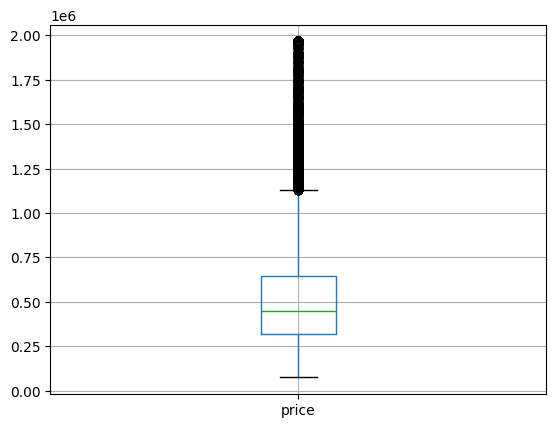

In [ ]:
df.boxplot("price")
plt.show()

In [ ]:
q_high = df["price"].quantile(0.99)
df["price"] = np.where(df["price"] > q_high, q_high, df["price"])

In [ ]:
X = df.drop("price", axis=1)
y = df["price"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(
        n_estimators=200, random_state=42
    ),
}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} -> R²: {r2:.4f}, RMSE: {rmse:.2f}")

Linear Regression -> R²: 0.8529, RMSE: 124683.32
Random Forest Regressor -> R²: 0.8877, RMSE: 108915.85
Gradient Boosting Regressor -> R²: 0.8957, RMSE: 104985.54


In [ ]:
param_grid = {
    "n_estimators": [300, 500, 700, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "subsample": [0.8, 0.9, 1.0],
    "max_features": ["sqrt", "log2", None],
}

In [ ]:
gbr = GradientBoostingRegressor(random_state=42)

In [ ]:
gbr_cv = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_grid,
    n_iter=30,  # number of random combinations
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=2,
    scoring="neg_root_mean_squared_error",  # optimize RMSE directly
    random_state=42,
)

In [ ]:
gbr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,GradientBoost...ndom_state=42)
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,30
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
print("Best params:", gbr_cv.best_params_)

Best params: {'subsample': 0.8, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.05}


In [ ]:
print("Best RMSE :", -gbr_cv.best_score_)

Best RMSE : 92585.19444639432


In [ ]:
best_gbr = gbr_cv.best_estimator_

In [ ]:
y_pred = best_gbr.predict(X_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
print(f"Tuned R²: {r2:.3f}")
print(f"Tuned RMSE: {rmse:.2f}")

Tuned R²: 0.917
Tuned RMSE: 93783.77


In [ ]:
with open("best_gbr_model.pkl", "wb") as f:
    pickle.dump(best_gbr, f)